## Lab 1.2 - Visualize Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. 

### Main objectives
After successful completion of the lab work students will be able to:
-   Analyze datasets with visualization techniques


### 1. Load data with real estate prices

In [1]:
# let's import pandas library and set options to be able to view data right in the browser
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')

In [2]:
# import math library which we'll need later for calculating metrics
import math
from sklearn.metrics import mean_squared_error

In [3]:
# load our dataset and see which data it contains.
spb_df = pd.read_table('data/spb.real.estate.archive.2018.tsv')

In [4]:
# Split data into Rent and Sell offers

rent_df = spb_df[spb_df.offer_type == 2]
sell_df = spb_df[spb_df.offer_type == 1]

### 2. Prepare cleaned dataset with RENT data in St.Peterburg without Oblast 

#### Recreating rent dataframe cleaned from outliers, with only SPb offers left

In [5]:
# Creating new column with price per square meter for each offer
rent_df['price_per_sq_m'] = rent_df.last_price/rent_df.area

# Creating new dataframe with median price per square meter for each house
house_rent_df = rent_df.groupby('unified_address').price_per_sq_m.median().reset_index()
house_rent_df.rename(columns = {'price_per_sq_m': 'house_price_sqm_median'}, inplace = True)

# Adding house median price per sq meter into main dataframe
rent_df = rent_df.merge(house_rent_df)

# Cleaning from expensive outliers
rent_df_cleaned = rent_df[~((rent_df.price_per_sq_m/rent_df.house_price_sqm_median) > 5)]
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned.last_price < 1000000]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m > 3000) 
                                    & ((rent_df_cleaned.house_price_sqm_median < 1000) 
                                       | (rent_df_cleaned.house_price_sqm_median == rent_df_cleaned.price_per_sq_m)))]

#Leaving only Saint-Petersburg apartments
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned.unified_address.str.contains('Россия, Санкт-Петербург')]

# Cleaning from cheap outliers
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 250) 
                               & (rent_df_cleaned.house_price_sqm_median/rent_df_cleaned.price_per_sq_m >= 2))]
rent_df_cleaned = rent_df_cleaned[~((rent_df_cleaned.price_per_sq_m < 200) 
                                          & (rent_df_cleaned.price_per_sq_m == rent_df_cleaned.house_price_sqm_median))]

<ipython-input-5-ac63d4e6f533>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df['price_per_sq_m'] = rent_df.last_price/rent_df.area


#### Checking for remaining outliers with a boxplot

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='last_price'>

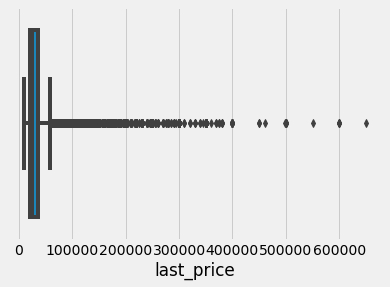

In [6]:
sns.boxplot(rent_df_cleaned['last_price'])

#### Creating function for charts

In [7]:
def sns_visualize_property(df, feature):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Price distribustion')

    # Histogram
    sns.histplot(ax=axes[0], x=df[feature])
    axes[0].set_title('Histogram')

    # QQ plot
    stats.probplot(df[feature], plot=axes[1])
    axes[1].set_title('QQ plot')

    # Boxplot
    sns.boxplot(df[feature], ax = axes[2])
    axes[2].set_title('Boxplot')

#### Building charts to inspect the distribution of the current data

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


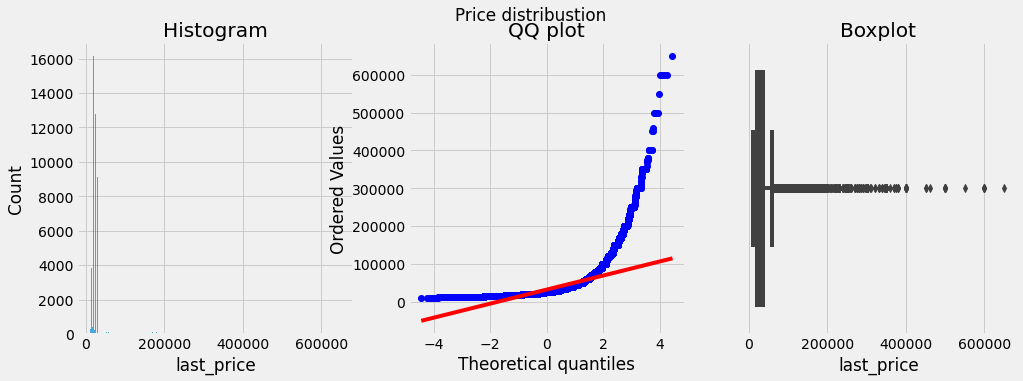

In [8]:
sns_visualize_property(rent_df_cleaned,'last_price')

In [9]:
rent_df_cleaned['last_price'].quantile(0.997)

200000.0

In [10]:
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned['last_price']<rent_df_cleaned['last_price'].quantile(0.997)]

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


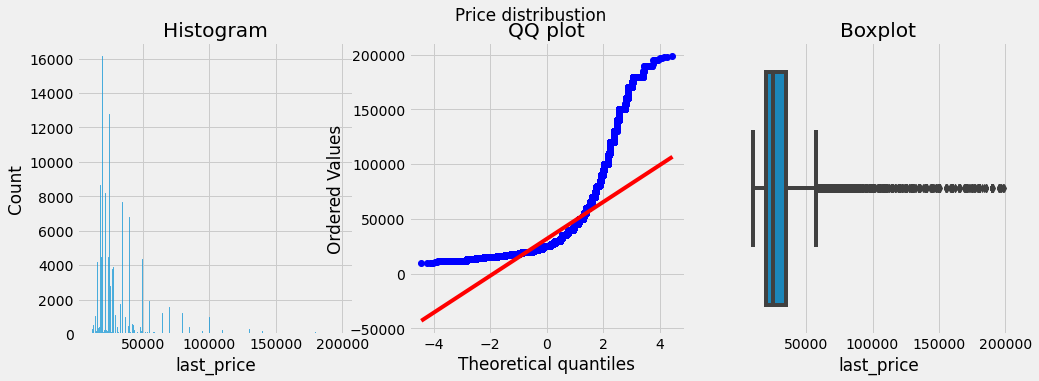

In [11]:
sns_visualize_property(rent_df_cleaned, 'last_price')

The target variable last_price is not normally distributed.
We'll try to apply logarithmic transformation:

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


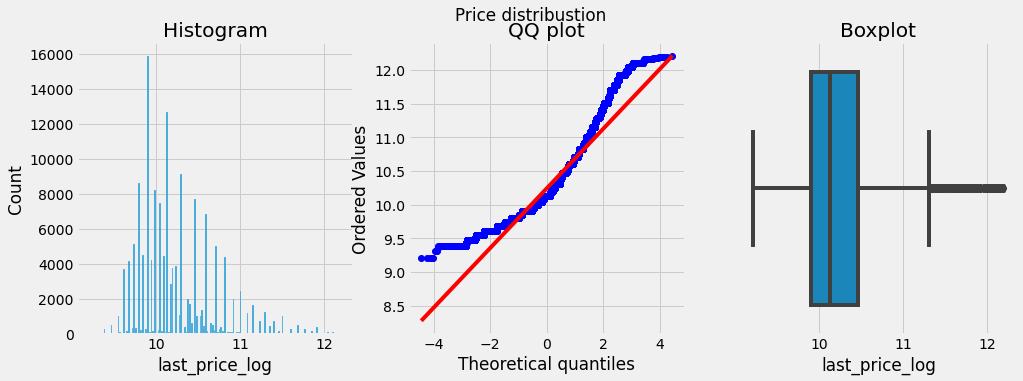

In [12]:
import numpy as np
rent_df_cleaned['last_price_log'] = np.log(rent_df_cleaned['last_price'])
sns_visualize_property(rent_df_cleaned, 'last_price_log')

#### Exploring missing values

<AxesSubplot:>

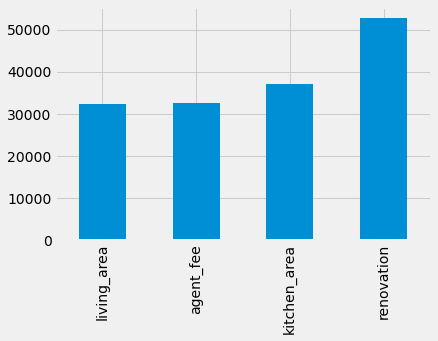

In [13]:
missing = rent_df_cleaned.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

#### Getting rid of uninformative features

We only have one offer_type and category_type in our dataset since we in the begginning only left rent offer. Thus these features can be dropped.

In [14]:
rent_df_cleaned['offer_type'].value_counts()

2    155392
Name: offer_type, dtype: int64

In [15]:
rent_df_cleaned['category_type'].value_counts()

2    155392
Name: category_type, dtype: int64

In [16]:
rent_df_cleaned.drop(columns=['category_type','offer_type'], inplace=True)

#### Getting rid of features with many missing values

In [17]:
rent_df_cleaned.drop(columns=['agent_fee'], inplace=True)

#### Filling in missing values in renovation, assuming a missing value here means no renovation

In [18]:
rent_df_cleaned['renovation'].fillna(0.0, inplace=True)

#### Looking at missing values again

<AxesSubplot:>

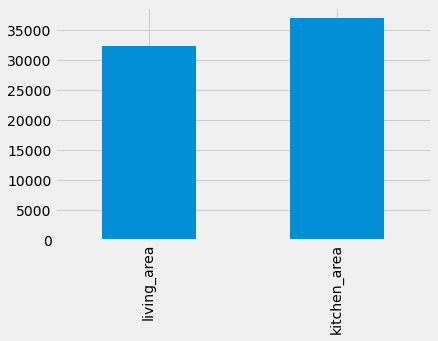

In [19]:
missing = rent_df_cleaned.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

Living_area and Kitchen_area should not be dropped since we expect them to be important for price prediction. They can later be imputed with values (mean, median, or other strategy) and will play a major role in predicting price.

#### Dropping auxiliary columns used previously for outliers detection and cleaning

In [20]:
rent_df_cleaned.drop(columns=['offer_id','price_per_sq_m','house_price_sqm_median'], inplace=True)

#### Dropping unified_address of the apartment

In [21]:
unified_address = rent_df_cleaned.pop('unified_address')

#### Cleaning outliers in kitchen_area

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='kitchen_area'>

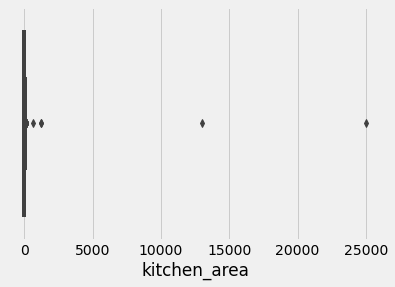

In [22]:
sns.boxplot(rent_df_cleaned['kitchen_area'])

In [23]:
rent_df_cleaned['kitchen_area'].quantile(0.997)

45.0

In [24]:
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned['kitchen_area']<rent_df_cleaned['kitchen_area'].quantile(0.997)]

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='kitchen_area'>

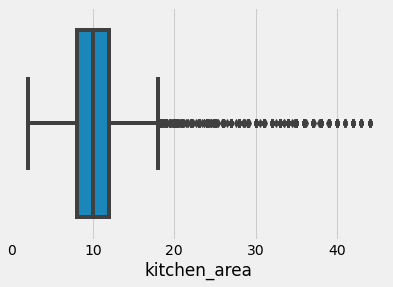

In [25]:
sns.boxplot(rent_df_cleaned['kitchen_area'])

#### Cleaning outliers in living_area

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='living_area'>

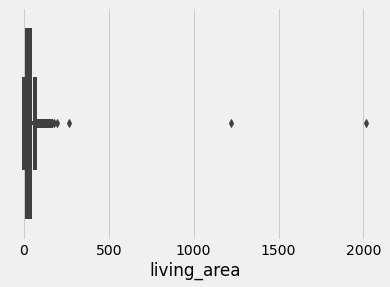

In [26]:
sns.boxplot(rent_df_cleaned['living_area'])

In [27]:
rent_df_cleaned['living_area'].quantile(0.997)

105.0

In [28]:
rent_df_cleaned = rent_df_cleaned[rent_df_cleaned['living_area']<rent_df_cleaned['living_area'].quantile(0.997)]

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='living_area'>

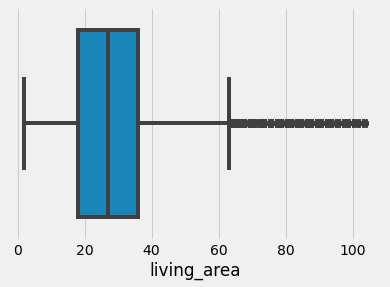

In [29]:
sns.boxplot(rent_df_cleaned['living_area'])

## Examining the relationship between price and remaining features

Remaining features:

In [30]:
rent_df_cleaned.columns

Index(['first_day_exposition', 'last_day_exposition', 'last_price', 'floor', 'open_plan', 'rooms', 'studio', 'area', 'kitchen_area', 'living_area', 'renovation', 'building_id', 'last_price_log'], dtype='object')

In [31]:
rent_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113716 entries, 0 to 171185
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   first_day_exposition  113716 non-null  object 
 1   last_day_exposition   113716 non-null  object 
 2   last_price            113716 non-null  float64
 3   floor                 113716 non-null  int64  
 4   open_plan             113716 non-null  bool   
 5   rooms                 113716 non-null  int64  
 6   studio                113716 non-null  bool   
 7   area                  113716 non-null  float64
 8   kitchen_area          113716 non-null  float64
 9   living_area           113716 non-null  float64
 10  renovation            113716 non-null  float64
 11  building_id           113716 non-null  int64  
 12  last_price_log        113716 non-null  float64
dtypes: bool(2), float64(6), int64(3), object(2)
memory usage: 10.6+ MB


In [32]:
rent_df_cleaned.head()

,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,building_id,last_price_log
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,False,1,False,28.0,8.0,20.0,3.0,6719200042030752141,9.903488
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,False,2,False,59.0,10.0,35.0,3.0,6719200042030752141,10.085809
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,False,1,False,36.0,9.0,17.0,3.0,6719200042030752141,9.798127
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,False,1,False,39.0,10.0,18.0,0.0,6719200042030752141,9.798127
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,False,1,False,36.0,8.0,18.0,11.0,6719200042030752141,9.852194


#### Separating features by data types: boolean, numeric and string

In [33]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [34]:
binary = [f for f in rent_df_cleaned.columns if rent_df_cleaned.dtypes[f] == 'bool']
print("Binary variables: {}".format(binary))

numeric = [f for f in rent_df_cleaned.columns if is_numeric_dtype(rent_df_cleaned[f])]
for f in binary:
    numeric.remove(f)
print("Numeric variables: {}".format(numeric))

qualitative = [f for f in rent_df_cleaned.columns if is_string_dtype(rent_df_cleaned[f])]
print("Qualitative variables: {}".format(qualitative))

Binary variables: ['open_plan', 'studio']
Numeric variables: ['last_price', 'floor', 'rooms', 'area', 'kitchen_area', 'living_area', 'renovation', 'building_id', 'last_price_log']
Qualitative variables: ['first_day_exposition', 'last_day_exposition']


#### Building scatterplots for numeric variables to examine relationship between price and these features

In [35]:
from ipywidgets import widgets
from IPython.display import display

features = {'FEATURE': numeric}

def chart(feature):
        sns.scatterplot(data=rent_df_cleaned, x=feature, y='last_price')

featureW = widgets.Dropdown(options=features['FEATURE'])

i = widgets.interactive(chart, feature=featureW) 
display(i)

interactive(children=(Dropdown(description='feature', options=('last_price', 'floor', 'rooms', 'area', 'kitche…

#### Exploring correlation between features

<AxesSubplot:>

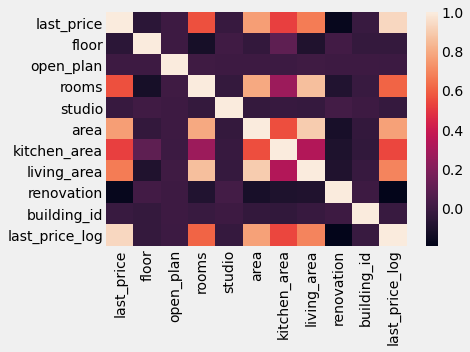

In [36]:
sns.heatmap(rent_df_cleaned.corr())

#### Plotting categorical features

In [37]:
categorical = ['floor','open_plan','rooms','renovation','studio']

In [40]:
features = {'FEATURE': categorical}

def chart(feature):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(feature)
    
    sns.stripplot(data=rent_df_cleaned, x=feature, y='last_price', ax = axes[0])
    axes[1].set_title('Stripplot')
    
    sns.boxplot(data=rent_df_cleaned, x=feature, y='last_price', ax = axes[1])
    axes[1].set_title('Boxplot')

        

featureW = widgets.Dropdown(options=features['FEATURE'])

i = widgets.interactive(chart, feature=featureW) 
display(i)

interactive(children=(Dropdown(description='feature', options=('floor', 'open_plan', 'rooms', 'renovation', 's…

#### Changing type of boolean variables to integer

In [41]:
rent_df_cleaned['open_plan'] = rent_df_cleaned['open_plan'].astype('int')
rent_df_cleaned['studio'] = rent_df_cleaned['studio'].astype('int')

#### Resulting dataset:

In [42]:
rent_df_cleaned.head(5)

,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,building_id,last_price_log
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,6719200042030752141,9.903488
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,0,2,0,59.0,10.0,35.0,3.0,6719200042030752141,10.085809
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,0,1,0,36.0,9.0,17.0,3.0,6719200042030752141,9.798127
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,0,1,0,39.0,10.0,18.0,0.0,6719200042030752141,9.798127
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,0,1,0,36.0,8.0,18.0,11.0,6719200042030752141,9.852194


# Self-control stops
1. What other factors might influence price? Think of the factors which can be actually calculated and included in the model.
2. Compete with other teams to create the best solution. You can play with factors and algorithm parameters to come up with it.

## 1. What other factors might influence price? Think of the factors which can be actually calculated and included in the model.

#### Year of initial publication of the offer on the website

Real estate prices are mostly rising as the time goes by. And although with the sell prices the trend is not generally linear as purchase real estate prices tend to fluctuate a lot due to a number of external factors, RENT prices, <i>we assume</i>, grow more straightforwardly: these prices depend more on landlords' decisions, who our usually individuals, private citizens, who are influenced in their daily lives by inflation, thus <i>we suppose</i> they raise the <i>nominal</i> rent price for their offers over time to account for this inflation that impacts them personally, and to keep their rental income <i>in real terms</i>.
<p>Thus we want to take into account <b>the year</b> of offer publication, since yearly inflation is a more interpretable measure.</p>

In [43]:
rent_df_cleaned['year'] = rent_df_cleaned.first_day_exposition.str.slice(start=0, stop=4).astype(int)

In [44]:
rent_df_cleaned['year']

0         2015
1         2015
2         2015
3         2016
4         2016
          ... 
171179    2018
171180    2018
171182    2018
171184    2018
171185    2017
Name: year, Length: 113716, dtype: int64

In [45]:
rent_df_cleaned['year'].dtype

dtype('int64')

#### Exposition duration: time from first to last day of exposition in days

Since our target variable is last_price, meaning it's the last from the whole range of prices for a particular apartment during the whole period of exposition, <i>we can assume</i> the time plays a role in the last_price formation. From common sense <i>we may suppose</i> that, as the time goes by, the longer the apartment is on the market, the lower the price will be. At the same time, the inflation plays its part: especially for apartments for RENT, the price tends to insrease as the time goes by. All in all, this way we can expect <b>exposition duration</b> to be an influential factor for the apartment price.

In [72]:
rent_df_cleaned['exposition_duration'] = pd.to_datetime(rent_df_cleaned.last_day_exposition) - pd.to_datetime(rent_df_cleaned.first_day_exposition)
rent_df_cleaned.exposition_duration = rent_df_cleaned.exposition_duration.dt.days

In [73]:
rent_df_cleaned.head(5)

,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,building_id,last_price_log,year,exposition_duration,av_room_area
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,6719200042030752141,9.903488,2015,360,20.0
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,0,2,0,59.0,10.0,35.0,3.0,6719200042030752141,10.085809,2015,108,18.0
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,0,1,0,36.0,9.0,17.0,3.0,6719200042030752141,9.798127,2015,159,17.0
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,0,1,0,39.0,10.0,18.0,0.0,6719200042030752141,9.798127,2016,24,18.0
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,0,1,0,36.0,8.0,18.0,11.0,6719200042030752141,9.852194,2016,34,18.0


#### Average room size

We'll also take into account the <b>average size of room</b>, calculated as the total living area of the apartment, divided by the number of habitable rooms (feature <i>'rooms'</i>). This <i>might be important</i> since two apartments can be equally large, but one will have a lot of small rooms, and another will have few, but large rooms, and these 2 apartments, despite similar total living area, might be priced differently and perceived differently by potential customers.
<p>Alternatively, 2 apartment can have similar number of rooms, but these rooms will differ in area, and larger rooms are usually priced higher.</p>
<p>All in all, we're getting at the fact that while both features <i>'rooms'</i> and <i>'living area'</i> are important for the price individually, they might not completely, exhaustively explain the dependency between apartment's parameters and its price. We would also like to look at the interaction of these 2 features, and calculating auxiliary feature <b><i>'average size of room'</i></b> might be a good solution.</p>

In [75]:
rent_df_cleaned['av_room_area'] = (rent_df_cleaned.living_area / rent_df_cleaned.rooms).round()

In [76]:
rent_df_cleaned.head(5)

,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,building_id,last_price_log,year,exposition_duration,av_room_area
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,6719200042030752141,9.903488,2015,360,20.0
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,0,2,0,59.0,10.0,35.0,3.0,6719200042030752141,10.085809,2015,108,18.0
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,0,1,0,36.0,9.0,17.0,3.0,6719200042030752141,9.798127,2015,159,17.0
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,0,1,0,39.0,10.0,18.0,0.0,6719200042030752141,9.798127,2016,24,18.0
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,0,1,0,36.0,8.0,18.0,11.0,6719200042030752141,9.852194,2016,34,18.0


## 2. Compete with other teams to create the best solution. You can play with factors and algorithm parameters to come up with it.

### First 'naive' attempt to build a predictive model:

#### Splitting data into train and test (hold-out) subsamples

In [86]:
train_df = rent_df_cleaned[(rent_df_cleaned.first_day_exposition >= '2018-01-01') 
                          & (rent_df_cleaned.first_day_exposition < '2018-04-01')]

X_train = train_df.drop(['last_price', 'last_price_log'], axis=1)

X_train.first_day_exposition = pd.to_datetime(X_train.first_day_exposition)
X_train.first_day_exposition = X_train.first_day_exposition.apply(lambda x: x.value)

X_train.last_day_exposition = pd.to_datetime(X_train.last_day_exposition)
X_train.last_day_exposition = X_train.last_day_exposition.apply(lambda x: x.value)

y_train = train_df.last_price

In [89]:
test_df = rent_df_cleaned[(rent_df_cleaned.first_day_exposition >= '2018-04-01') 
                          & (rent_df_cleaned.first_day_exposition < '2018-06-01')]

X_test = test_df.drop(['last_price', 'last_price_log'], axis=1)

X_test.first_day_exposition = pd.to_datetime(X_test.first_day_exposition)
X_test.first_day_exposition = X_test.first_day_exposition.apply(lambda x: x.value)

X_test.last_day_exposition = pd.to_datetime(X_test.last_day_exposition)
X_test.last_day_exposition = X_test.last_day_exposition.apply(lambda x: x.value)

y_test = test_df.last_price

#### Importing Sklearn tools

In [92]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

#### Choosing linear model through GridSearch

In [85]:
en = ElasticNet()

params=dict(alpha=np.linspace(0.05, 1, 5).tolist(), 
                  l1_ratio=np.linspace(0, 1, 5).tolist())

en_cv = GridSearchCV(en, param_grid=params, scoring='neg_root_mean_squared_error', 
                        cv=5, n_jobs=1, verbose=1)

en_cv.fit(X_train.drop(['first_day_exposition', 'last_day_exposition'], axis=1), y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544509014131.4196, tolerance: 254320110.8293673
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525549901049.13007, tolerance: 251736379.41323665
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550952278063.6014, tolerance: 267654996.36957726
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529092872603.7605, tolerance: 251736379.41323665
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554973310711.3989, tolerance: 267654996.36957726
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544098441918.7207, tolerance: 255133023.95530772
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective 

GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=1,
             param_grid={'alpha': [0.05, 0.2875, 0.525, 0.7625, 1.0],
                         'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

#### Examining results

In [91]:
pd.DataFrame(en_cv.cv_results_)[['params', 'mean_test_score',
                                   ]].sort_values('mean_test_score', ascending=False).style.bar(vmin=0)

,params,mean_test_score
3,"{'alpha': 0.05, 'l1_ratio': 0.75}",-11100.872267
24,"{'alpha': 1.0, 'l1_ratio': 1.0}",-11100.893386
19,"{'alpha': 0.7625, 'l1_ratio': 1.0}",-11100.905847
14,"{'alpha': 0.525, 'l1_ratio': 1.0}",-11100.918562
9,"{'alpha': 0.2875, 'l1_ratio': 1.0}",-11100.931532
4,"{'alpha': 0.05, 'l1_ratio': 1.0}",-11100.944756
2,"{'alpha': 0.05, 'l1_ratio': 0.5}",-11105.305194
1,"{'alpha': 0.05, 'l1_ratio': 0.25}",-11109.519401
0,"{'alpha': 0.05, 'l1_ratio': 0.0}",-11113.009242
8,"{'alpha': 0.2875, 'l1_ratio': 0.75}",-11117.652141


#### Calculating RMSE for hold-out sample

In [98]:
mean_squared_error(y_test, en_cv.predict(X_test.drop(['first_day_exposition', 'last_day_exposition'], axis=1)), squared=False)

10976.61359120051

## Intermediate conclusion

Resulting RMSE is huge, so there's still much room for model improvement.

We might want to scale our features, introduce transformations, such as Polynomial featyres, etc.

So this will be done in the next lab.